In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.datasets import load_breast_cancer
from torchvision import datasets, transforms

In [4]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
df['class'] = cancer['target']
df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [5]:
data = torch.from_numpy(df.values).float()
X = data[:, :-1]
y = data[:, -1:]
X.shape, y.shape

(torch.Size([569, 30]), torch.Size([569, 1]))

In [6]:
ratios = [0.6, 0.2, 0.2]
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]
cnts

[341, 113, 115]

In [7]:
indices = torch.randperm(data.shape[0])
X = list(torch.index_select(X, dim=0, index=indices).split(cnts, dim=0))
y = list(torch.index_select(y, dim=0, index=indices).split(cnts, dim=0))

for X_i, y_i in zip(X, y):
    print(X_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [8]:
scaler = StandardScaler()
scaler.fit(X[0].numpy())
X[0] = torch.from_numpy(scaler.transform(X[0].numpy())).float()
X[1] = torch.from_numpy(scaler.transform(X[1].numpy())).float()
X[2] = torch.from_numpy(scaler.transform(X[2].numpy())).float()

In [9]:
model = nn.Sequential(
    nn.Linear(X[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid()
)
optimizer = optim.Adam(model.parameters())

In [10]:
n_epochs = 5000
batch_size = 16
print_interval = 100

In [11]:
lowest_loss = np.inf
lowest_epoch = np.inf
best_model = None
early_stop = 200

In [12]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(X[0].shape[0])
    X_ = torch.index_select(X[0], dim=0, index=indices).split(batch_size, dim=0)
    y_ = torch.index_select(y[0], dim=0, index=indices).split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)
    
    train_loss = train_loss / len(X_)

    with torch.no_grad():
        X_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0
        
        for X_i, y_i in zip(X_, y_):
            y_hat_i = model(X_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)

            valid_loss += float(loss)
            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(X_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.6f}, valid loss={valid_loss:.6f}, lowest loss={lowest_loss:.6f}')

    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.6f}')

model.load_state_dict(best_model)

Epoch 100: train loss=0.000096, valid loss=0.254885, lowest loss=0.072895
Epoch 200: train loss=0.000009, valid loss=0.347137, lowest loss=0.072895
There is no improvement during last 200 epochs.
The best validation loss from epoch 20: 0.072895


<All keys matched successfully>

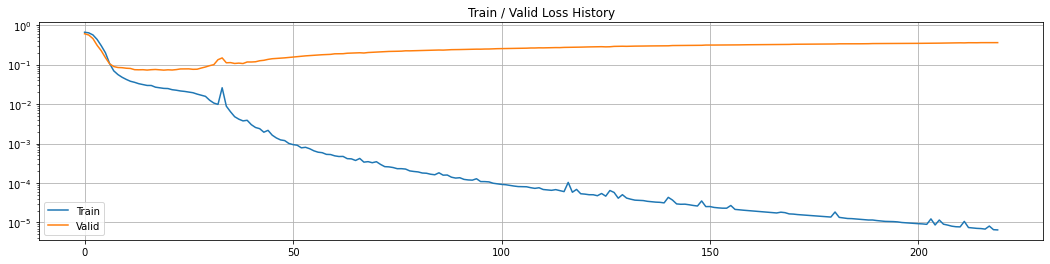

In [13]:
plot_from = 0

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [14]:
test_loss = 0
y_hat = []

with torch.no_grad():
    X_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(X_)
y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.6f}')
print(f'Valid loss: {sorted_history[0][1]:.6f}')
print(f'Test loss: {test_loss:.6f}')

Train loss: 0.025105
Valid loss: 0.072895
Test loss: 0.115024


In [15]:
correct_cnt = (y[2] == (y_hat > 0.5)).sum()
total_cnt = float(y[2].size(0))

print(f'Test Accuracy: {correct_cnt / total_cnt:.4f}')

Test Accuracy: 0.9652


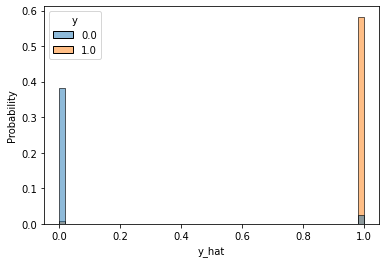

In [16]:
df = pd.DataFrame(torch.concat([(y_hat > 0.5).float(), y[2]], dim=1).detach().numpy(), columns=['y', 'y_hat'])
sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()

In [17]:
roc_auc_score(df.values[:, 0], df.values[:, 1])

0.9607321652065082

In [18]:
train = datasets.MNIST('../data', train=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [19]:
def plot(X):
    img = (np.array(X.detach().cpu(), dtype='float')).reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

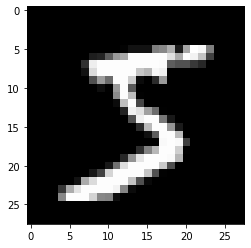

In [20]:
plot(train.data[0])

In [21]:
X = train.data.float() / 255
y = train.targets
X = X.reshape(X.size(0), -1)
X.shape, y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [22]:
input_size = X.size(-1)
output_size = int(max(y)) + 1

In [23]:
ratios = [0.8, 0.2]
train_cnt = int(X.size(0) * ratios[0])
valid_cnt = X.size(0) - train_cnt
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]
cnts

[48000, 12000]

In [24]:
indices = torch.randperm(len(train.data))
X = list(torch.index_select(X, dim=0, index=indices).split(cnts, dim=0))
y = list(torch.index_select(y, dim=0, index=indices).split(cnts, dim=0))
X += [(test.data.float() / 255).reshape(test_cnt, -1)]
y += [test.targets]

for X_i, y_i in zip(X, y):
    print(X_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [25]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1)
)
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [26]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [27]:
model = model.to(device)
X = [X_i.to(device) for X_i in X]
y = [y_i.to(device) for y_i in y]

In [28]:
n_epochs = 800
batch_size = 256
print_interval = 100
lowest_loss = np.inf
lowest_epoch = np.inf
best_model = None
early_stop = 100

In [29]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(X[0].size(0))
    X_ = torch.index_select(X[0], dim=0, index=indices).split(batch_size, dim=0)
    y_ = torch.index_select(y[0], dim=0, index=indices).split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)

    train_loss = train_loss / len(X_)

    with torch.no_grad():
        X_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for X_i, y_i in zip(X_, y_):
            y_hat_i = model(X_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)
            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(X_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.6f}, valid loss={valid_loss:.6f}, lowest loss={lowest_loss:.6f}')
    
    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.6f}')

model.load_state_dict(best_model)

Epoch 100: train loss=0.000000, valid loss=0.176796, lowest loss=0.088732
There is no improvement during last 100 epochs.
The best validation loss from epoch 8: 0.088732


<All keys matched successfully>

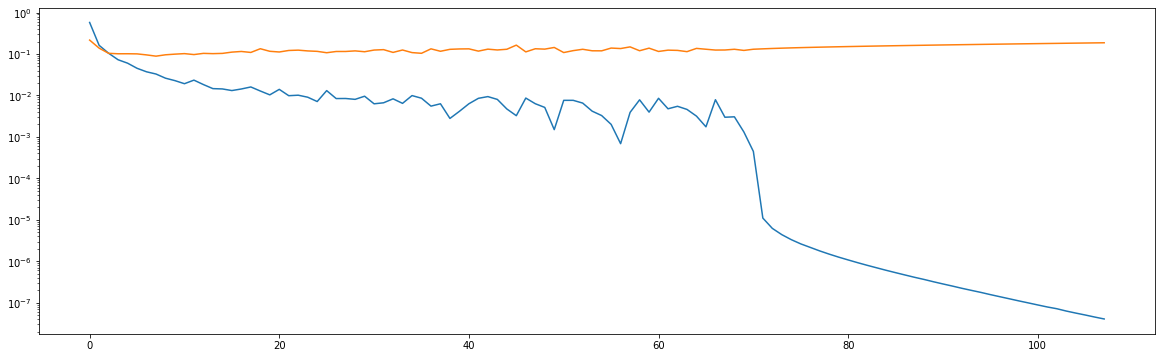

In [31]:
plot_from = 0

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
        range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.yscale('log')
plt.show()

In [32]:
test_loss = 0
y_hat = []

with torch.no_grad():
    X_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)
    
    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(X_)
y_hat = torch.concat(y_hat, dim=0)

print(f'Test loss: {test_loss:.6f}')

Test loss: 0.089474


In [44]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))
float(correct_cnt / total_cnt)

0.9750999808311462

In [45]:
pd.DataFrame(confusion_matrix(y[2], torch.argmax(y_hat, dim=-1)), index=[f'True_{i}' for i in range(10)], columns=[f'Pred_{i}' for i in range(10)])

,Pred_0,Pred_1,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6,Pred_7,Pred_8,Pred_9
True_0,968,0,3,0,1,1,1,0,1,5
True_1,0,1126,1,0,0,0,2,0,6,0
True_2,3,5,1010,4,2,0,1,2,5,0
True_3,0,0,2,994,0,7,0,3,4,0
True_4,0,1,2,0,965,0,5,2,3,4
True_5,3,0,0,17,1,857,4,1,5,4
True_6,5,2,1,0,7,6,936,0,1,0
True_7,1,8,13,2,1,0,0,991,1,11
True_8,4,2,5,14,1,4,1,2,940,1
True_9,2,3,3,11,11,2,0,6,7,964
